# Study usage of suspect hashtag

## Import

In [1]:
import pandas as pd
import json
import numpy as np
import re
from itertools import repeat

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

from concurrent.futures import wait as futures_wait
from concurrent.futures.process import ProcessPoolExecutor

import importlib
import hashtag_util as ut

## Dataset preparation

In [2]:
df = pd.read_csv('../tweets.csv',low_memory=False,
                 usecols=['hashtags','user_screen_name','created_at','user_created_at','user_code_error'])

df

,created_at,user_screen_name,user_created_at,hashtags,user_code_error
0,Thu Oct 01 23:05:18 +0000 2020,alessia_smile6,Sat Sep 01 18:36:08 +0000 2018,[],NaN
1,Thu Oct 01 23:42:33 +0000 2020,GiornaledPuglia,Fri Feb 12 09:11:24 +0000 2010,[],NaN
2,Thu Oct 01 23:10:10 +0000 2020,TestPerTutti,Sun Jul 05 09:37:48 +0000 2020,[],NaN
3,Thu Oct 01 22:42:17 +0000 2020,CapitanHarlok6,Fri Jan 10 23:37:56 +0000 2020,[],NaN
4,Thu Oct 01 23:15:04 +0000 2020,soteros1,Tue Jul 01 17:29:02 +0000 2014,[],NaN
...,...,...,...,...,...
4053196,Tue May 18 11:05:08 +0000 2021,CiaoGrosso,Sun Jan 15 17:25:21 +0000 2012,[],NaN
4053197,Tue May 18 11:05:13 +0000 2021,Rosskitty77,Sun Feb 19 18:26:36 +0000 2012,[],NaN
4053198,Tue May 18 11:04:42 +0000 2021,GuidoIafrate,Mon Jan 22 22:43:30 +0000 2018,[],NaN
4053199,Tue May 18 11:04:45 +0000 2021,lucabattanta,Thu Jul 16 15:14:03 +0000 2009,"[{'text': 'lariachetira', 'indices': [14, 27]}]",NaN


In [3]:
df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %X %z %Y")

In [4]:
listHashtagsStudy = ['5g','bill.*','dittatura*.','.*disobbedisco','nessunacorrelazione','byoblu*.','noobbligo.*']

In [5]:
dfUse = ut.process_df_uses_hashtags(df,listHashtagsStudy)
dfUse

,user,5g,bill.*,dittatura*.,.*disobbedisco,nessunacorrelazione,byoblu*.,noobbligo.*
0,daniele19921,False,False,False,False,False,False,False
1,daniele19921,False,False,False,False,False,False,False
2,RossellaPierac3,False,False,False,False,False,False,False
3,RossellaPierac3,False,False,False,False,False,False,False
4,ZombieBuster5,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2172628,ELENAGORINI2,False,False,False,False,False,False,False
2172629,Katia48386800,False,False,False,False,False,False,False
2172630,PredragLecic,False,False,False,False,False,False,False
2172631,PredragLecic,False,False,False,False,False,False,False


In [6]:
dfUseHashtag = dfUse.groupby('user').any()
dfUseHashtag['user_created_at'] = pd.to_datetime(df.groupby('user_screen_name').first()['user_created_at'],
                                                 format="%a %b %d %X %z %Y")
dfUseHashtag['user_error'] = df.groupby('user_screen_name').first()['user_code_error']

In [7]:
dfUseHashtag = ut.hashtagAND(listHashtagsStudy,dfUseHashtag)
for i in range(1,len(listHashtagsStudy)):
    dfUseHashtag = ut.hashtagOR(listHashtagsStudy,dfUseHashtag,'OR'+str(i),i)

In [8]:
dfUseHashtag

,5g,bill.*,dittatura*.,.*disobbedisco,nessunacorrelazione,byoblu*.,noobbligo.*,user_created_at,user_error,AND,OR1,OR2,OR3,OR4,OR5,OR6
user,,,,,,,,,,,,,,,,
00000o0OOOO00,False,False,False,False,False,False,False,2014-07-27 22:45:37+00:00,NaN,False,False,False,False,False,False,False
000Rizzo,False,False,False,False,False,False,False,2014-05-15 20:04:39+00:00,NaN,False,False,False,False,False,False,False
000oro000,False,False,False,False,False,False,False,2019-06-28 15:46:03+00:00,NaN,False,False,False,False,False,False,False
000qwerty777,False,False,False,False,False,False,False,2013-06-13 21:50:48+00:00,NaN,False,False,False,False,False,False,False
00222317L,False,False,False,False,False,False,False,2015-02-12 17:18:38+00:00,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zziocane66,True,True,False,False,True,False,False,2020-01-01 01:54:01+00:00,NaN,False,True,True,True,False,False,False
zzolgima_imma,False,False,False,False,False,False,False,2011-12-12 11:14:43+00:00,NaN,False,False,False,False,False,False,False
zzostru,False,False,False,False,False,False,False,2018-07-21 11:59:53+00:00,NaN,False,False,False,False,False,False,False


## General study of the hashtags

In [9]:
for i in range(1,len(listHashtagsStudy)):
    print("User that have used at least %d hashtags (%i)"%(i,sum(dfUseHashtag['OR'+str(i)])))
    for u in dfUseHashtag.index:
        if dfUseHashtag['OR'+str(i)][u]:
            print("\t%s"%u)


User that have used at least 1 hashtags (6990)
	00_h16
	00ann000
	05Varf
	0Cicerone
	101AnagrammiZen
	10clarenc3
	11secon
	12qbert
	13mari81
	14_88_666
	15Nevermind
	16q___
	17Enomis
	17_vin
	18_agosto
	1950_anna
	1956lia
	1971itimpa
	1973Dario09
	19TIZIANO72
	19marino74
	1AsinoKeVola
	1Clochard
	1GROSSI
	1Marzia2
	1Swedemborg
	1UnPassante
	1guadagn
	1marcoo
	1nove71
	1tal1al1b3ra
	2000fallito
	2002MMAD0691
	2009Daria
	2009Lelle
	2014Monaco
	2016shift
	21lettere
	2312_leonardo
	23neroecamilla
	25O319
	25gennaio1
	2631925
	270349
	27crazyfrog
	27ottobre2020
	280juliet
	2849Dama
	2Biagetti
	2Foye
	2Qrocky
	2_crim
	2_italie
	2b341b94244240a
	2essera
	2minutesweb1
	2piedi
	300Italia
	30mirella51
	361_magazine
	366daniele
	3Cardi
	3dc8
	470simone
	4T_Mexico_
	4everAnnina
	4maipiu4
	501_tot
	59Dipendente
	5Selector
	5dancingis
	60_cla
	6166467278004cc
	64Almo
	65_virna
	666Burzum777
	69Brancato
	69Nique
	6harvest_ny
	73Orlando73
	73rv
	74Sticca
	74_cappe
	75Ginny
	77mikemason
	7August17
	7__

	De51Fra
	Deangaia1
	DeathOfaSalesma
	Debora98398253
	DecimoGianni
	DeerEwan
	DefectorOf
	DeficitMiManchi
	DeganisFabrizio
	DelgadoSveva
	DelleChiaiePia
	Delorenzoanna1
	Delphi24782968
	DemianReal
	DenLombardo
	DennisAngemi
	DenteEleonora
	DesDemona2004
	Descent21011183
	Destradipopolo
	DevaMati
	Devizzz_
	Devosceglierlo
	DiImmobiliare
	DiPint3
	DiReddito
	Diabolikart
	DiacronicoMurra
	DiamanteGiallo
	DianaLanciotti
	DianaNapolitan4
	Diddi61075948
	Diego90190488
	Diego94601132
	DiegoA20_17_38
	DiegoCa_73
	DiegoFracasso1
	DiegoPetracca27
	Diego_Bruno80
	DigitalMatt3
	DimKomesarios
	Dinbsky
	Diogene55
	DiogeneIlCinic1
	Dionisio_lysios
	DipinoFrancesco
	DiplomaziaTW
	Diseredato1
	DivaCandida
	Diva_VIP
	DocDisco81
	DoctorWho744
	Doctorennada1
	Doddy055
	DogeViva
	Domen35
	Domenic20508867
	Domenic97633723
	DomenicInvictus
	DomenicaCoriDC
	DomenicaGianne4
	Domenico1oo777
	DomenicoScanab1
	DomenicoSortino
	Domenico_p6
	DomingoRizzuto
	Domy61905088
	DonLega
	DonaFazzino
	Donatel64264869
	Donat

	JusticeGio
	JustynaG15
	JutsuRicky
	Juventa55317671
	K274863601
	KNunsesa
	KZeneise
	Kaiser993
	KappaVu
	Kappawowi
	KarlEmme1
	Karm3nB
	Kasaphan
	Kaveio1
	KayeMenner
	KegOfGrog
	Kemess12
	KentAllard23
	Keynesblog
	Kick57624616
	KimmyPaca
	Kimstellata
	KitemuoT
	KittyGodeanu
	Koiroiro
	KopenScott47
	Kotiomkin
	KraeuterVerbena
	Krazy9Kat
	KrisGxx
	Krono65
	KsiazeMarek
	Kugoale1
	KurganGang
	Kutaro88
	Kwahadis
	Kwizera06428241
	L1C1L1C1
	L824824179
	LARROTINO3
	LAURADEPS
	LB19712
	LB85693099
	LBaccio
	LBasemi
	LBertacchini
	LBiglione
	LBollite
	LBrugioni
	LCatarchi
	LDRaimondo
	LDegani
	LEBBY4EVER
	LESOVICI
	LFacciato
	LHoesle
	LKlimex
	LKynes4
	LL_LXIII
	LLombard0
	LM13dec
	LMindreanu
	LNN999
	LONG00885513
	LPPelletier83
	LPincia
	LUCABRAMBILLA24
	LUCCHINA_
	LUCIABR94458490
	LUCIANA75087178
	LUIGIVACCARO5
	LUniversoVibra
	L_F_Sternn
	L_Pigna
	L_oeildujour
	La7tv
	LaBetty45814714
	LaCortopassi
	LaDashesse
	LaDiogene
	LaFranci27
	LaLaura68
	LaLestofante
	LaMammaN1
	LaMentegatta
	LaPrimaMa

	Penultimo6
	Peonia249
	Pepautore
	Peppe24245235
	PeppePeraino
	Peppeparma75
	Peppezappulla
	PerassoSuperba
	PereDempeus
	Perla19733917
	PerozziGiorgio
	PersilQ
	PesceFassio
	PeterPa19282107
	Peter_Italy
	Peter_Triscio
	PetraSugarFox
	PetrazzuoloF
	Petrocean
	PetroneIvan
	Petrons1597
	PetrusPietro
	PettinatiOscar
	Pheeleenee
	Phil_83
	PhilippoTrapani
	PiccariRaffaele
	PicchioRocca
	PicciStrix
	Piccole_Note
	PickleRick_22
	PicodaMirandola
	PieCicci74
	PierDavide1
	PierantoniFabio
	Pierfanze208
	Pierfra1966
	Piero42395724
	PieroVendramel
	Piero_Strada
	Pierorezzacapa
	PierpaV
	Pietro59359863
	PietroOlma
	Pietro_Otto
	Pimander1
	PinkFreud009
	PinucciaTrapan1
	Pinuccio6512
	PioRocchi
	PioRusso_79
	PiramideRossa
	PiscopoNicola97
	Pisticcese
	Pixty3
	Pizzetto73
	Pizzi997
	PoClaudia
	Poiana46
	Pol3etaff_stuff
	PolitikoReal
	Ponta84roll
	Popagni
	PostBreve
	Postfin
	Potemkin959
	PoveroUn
	Pow_Wow_Indian
	PpPagliaro
	Ppr_11
	PraesesMundi
	PresMoratti
	Presente_3
	PrideOfFreedom
	PrimaiLavorator

	VittorioBanti
	VittorioBuratti
	VittorioCocive1
	VittorioFerram1
	VizTheWiz2
	VladiNeri
	Vm777Ita
	Voi_Sapete_Chi
	Voroklimef
	VotersItalia
	VoxClamantis5
	VoxNewsInfo2
	Vulcanelios
	W3LF0
	WCostituzione
	WSdavidONE
	WYXYOVANNI55
	Wakeitalia
	Wallace_W_88
	WaltKowalski18
	Walter09251773
	Walterstranger
	Weefu4
	Wertigo6
	WhisperCar
	WhitePoolMilano
	WiertelB
	Willi_Shake_01
	WillyCoyote6
	WilsonGomezGB
	WilsonM43416954
	Winches73529523
	Wolf09722148
	WomanInBlack24
	WomenCodersBot
	XYZxyzY6
	X_poche_persone
	Xdeso
	Xevious_Xevious
	Xueza_00
	YRetlaw
	YerleShannara
	Yi_Benevolence
	Yngwie50424203
	YoMeAbstengo
	You_go77
	Yujumuzh
	YukiNek56432140
	Yuli_1984
	Yuppy561
	YzxvCfIgoewi95s
	Z3r0Rules
	ZGravita
	ZTL29492447
	ZaffutoCarmelo
	Zaira_Bartucca
	Zamberlett
	Zampaglion
	ZanRoby
	ZanellaRina
	Zaqq__
	Zdenek_ita
	Zedar73
	ZenatiDavide
	Zeta_user
	ZettiGiuliano
	Zeustacchio76
	ZiO_Iv0
	ZiaCandida
	ZiaGabriella1
	ZioClint
	ZioGnagno
	ZioKlint
	Zitellapersemp1
	ZombieBuster5
	Zoth2021
	Z

	dansalim
	dansedanslanuit
	dante24800883
	danteguest1
	dantess68
	danythodd
	dar_casartelli
	dar_riee
	dargento24
	darianichele
	dario88799
	darioconte66
	dariocurcio5
	dariodav711
	dariodenni
	dariophoto69
	darykerry
	davemik71
	davide_dalmonte
	davidedavideDG
	davidefigoli
	davidemarchiani
	davidepress
	dayflyer
	dcalpirela
	ddNTPs
	ddgiusto
	ddinno
	deb_first1
	deboramau
	decentralized33
	decfede
	decleves277
	dei_alba
	dekankeraar
	delittodic0gne
	dellandro58
	delphi_guru
	delphinedebauve
	dema_nous
	demarialuca
	demian_online
	derek_zth
	derpaul97
	desibros70
	desnos_bob
	deviance_
	devitocarmine
	devjdian
	dgx2018
	diStefanoClaudi
	di_socio
	dia_fox5
	dianaterza
	dib309mar
	diegocatalano77
	diegoimbriani
	diegomeloni
	diegopescarini
	diffid3nt3
	digibaby
	dileguossi
	dina_mladinov
	dino_modugno
	dinunziogio
	diogene2142
	dipego
	disicaterina
	disinformatia
	ditestamia75
	ditron99
	divanomat
	djanghuez
	djnutria57
	dlafangof
	dntmwmessageman
	docmanu83
	dod_63
	doe_uno
	dok2172
	

	iusdatumsceleri
	ivan28281
	ivan71439634
	ivana1957
	ivanacristofane
	ivanleonte
	ivantulipano
	ivocamic
	ivomez
	iwnnabeurslave
	jabbaTM
	jack_piccardo
	jacketizi
	jackgibiino
	jacopogiliberto
	jadarf1
	janet_isles
	janlucas1971
	jasarche
	jasondm30
	jb_jusy
	jchernandezjazz
	jeansky1
	jeck1979
	jeegrobotz
	jekkko1
	jememien
	jer1741
	jeremyWulc
	jerryMassloII
	jetblackhmari
	jhack
	jjiimmoo88
	jmaurosurf
	jobwithinternet
	joepanther
	johnnyargo1
	johnnypoz2
	johnway30716151
	jopratix
	joseadss
	josedal65
	joy65055188
	joyreal68
	juancar80
	juanjonieto79
	juanne78
	jubektwitt
	juggysart
	julesbeton
	julie_caillaux
	julyadesigraci
	julyah4
	jumpedsword
	junqueira2018
	justfastF1
	justicefreedomQ
	justicefreedomW
	justicefreedomY
	juvemyheart
	jxgiuliano
	kalyaMail
	kappamary
	katadaniele
	kategullo75
	katerinal1979
	katrinyanuo
	katun79
	kedryn
	kelevra310
	kermit290179
	kesause
	kiara86769608
	kickmyballs222
	kitersan
	kitta1979
	kittimanda
	kiuspo73
	klaudiko
	koaz74
	kokonews5
	kok

	papavero27
	papel61
	paradojadeluxe
	paradoxMKD
	paranzafritta
	paridepuglia
	parkland591
	parpinellivo
	pascat2
	paschesco
	pasq97esposito
	pasquale_carta
	pasquamarco
	patarini1045
	patfigu21155698
	patrinelli
	patriotaribelle
	patripatty5
	patriziagatto3
	patriziarn
	patriziarutigl1
	patroclo1991
	pattypattt
	paulpaeven
	paulre01
	paxal78
	pazzodicalcio
	pbenedetti50
	pbrex668
	pdnetwork
	pecosbi52896272
	pelias01
	pelo80
	pensierocritic1
	pensierofree
	pentagram54
	peoplexplanet
	pepebigne
	peportasryles
	pepp313
	peppamat7
	peppe844
	peppiniellopz
	peppins_logo
	pepppe772
	perchiresta
	pergiove72
	peru1981
	pesorati
	peterbonda007
	petersenjoe
	pewdiepies10
	phabiomocci
	phanormus
	phedra0379
	philallemant
	philthemvsic
	pi2py
	picchios85
	piccologabri
	pidioiscariota
	pieisos
	piemarcy
	piemofran
	pier2856
	pier_lamberti
	pierb1997
	pierfaviz
	pierluca_mussi
	piero636
	pierofreddio
	pierotorchi
	piersar62
	pietro30199674
	pietro_nurra
	pigramar
	pimpiripettepam
	pinklight22
	pip

	wainerpe
	wallemura
	walter_esse
	we_ci65
	weedjee
	weeiirdoo
	wesandkiedis
	wiertelwiertel
	wildmixfly
	wilsonR54727267
	wilvis1970
	with_earphones
	wjldflower_
	wojak0
	wrtl33t
	wushurabbit
	x4ndrodoc
	xHayleysmuffin
	xbensp
	xblunotte
	xdorotheax
	xenonian1
	xfarfax
	xilax65
	xpeoplelikeus
	xposeidone
	xsoniadm
	xx_Fabrizio_xx
	xx_thebossx
	yarialessi
	yellowbeppe
	yoygiada
	yufalcediluna
	yuko29616397
	zagararossa
	zagreus39922475
	zamlap
	zan62
	zaneroga
	zannazyu
	zaraluc50
	zarlino
	zazoomblog
	zazouland3
	zengalorenzo
	zenonepoli
	zenzero20
	zephira_137
	zephyrus_ads
	zeriantisisma
	zioTOLO
	ziofa73
	ziosam01
	zirudela
	zittononcisto
	zivale77
	zoepenelope_b
	zombiturbo
	zompiro22
	zucca64
	zuletamerchan
	zziocane66
User that have used at least 2 hashtags (1650)
	101AnagrammiZen
	10clarenc3
	12qbert
	1950_anna
	1GROSSI
	1nove71
	25O319
	2_crim
	2_italie
	2essera
	2piedi
	4everAnnina
	4maipiu4
	6166467278004cc
	69Nique
	6harvest_ny
	74_cappe
	75Ginny
	8_ferro
	9091campioni
	ACC

	francescomila18
	francobaietti
	francoliver2
	frant42
	franzulli77
	fratuccio2
	freddie_scorpio
	fremo03893514
	frescofrenki
	friggitricee
	fringuello
	g_piacente
	g_zerbato
	gabrillasarti2
	gabryjoy
	gaejimmy
	gael99
	gaetanomaisto
	gaiagioiared
	galata_mf
	ganga2410
	garosi_andrea
	gattotattoo
	generacomplotti
	gettasofia
	gfrisoli
	ghioldip
	giancarloalber9
	gianluca826
	gianni04116538
	giannisassari08
	gianppaolo
	gieffeci71
	giek2
	gioiami68701904
	giomo2
	giorgio2181953
	giornalettismo
	giovangolo
	giovann58134961
	giovanni_7
	giovannitrivel3
	giuli58888888
	giuliaemme2
	giuliog
	giuseppeadurno
	giuseppelacara
	giuseppelandi
	gjscco
	gloriosacombat
	gordonzar
	gpcassandra63es
	gplmetano
	graaf63
	granati_mauro
	grande_luciano
	grazpetrucci
	grecale66
	grigiocemento
	guyfawkes2_0
	hetzmichnicht1
	hipsterdelcazzo
	hofattotardi
	hondanomala
	horusarcadia
	iSam1190
	ibisrosso
	idkesse
	ienablinski
	igorlorenzo0
	igsolkr
	il30filosofo
	ilTeoLugarini
	il_bagatto
	il_brigante07
	il_cup

	ItalyoutofEu
	IulianaAdriana3
	IvoAyrton
	JPCK72
	Josep52598440
	Karm3nB
	LB19712
	LKynes4
	LPincia
	LUCIANA75087178
	Ladygalga1
	LallaM40589392
	Lanf040264
	Laura64135537
	LauraCarrese
	LeoFiorino
	LeoNoeuro
	Leonard13___
	LeveHome
	LiaColombo1
	LiberoFreedom
	Liberop79653844
	LifeJoining
	Limbolimbo18
	Llukas79
	LoredanaNavarra
	Loredanataberl1
	Lorenzxo2
	Luanastretti1
	LucaNestaOrland
	LucaRic21703581
	Lucia20352560
	LuigiF97101292
	LukyMe90
	Luna61710831
	Lunababaccetto
	M5S_No_Grazie
	MMHemlock
	MNdatv
	MSator
	M_4_R_C_O
	MaMaurizi9
	Maksmirto
	Mania48Mania53
	ManuQ24916888
	Marcell77640487
	MarcelloBussi
	MarceloTanomix
	Marcoc10
	Marcolit67
	MariMario1
	MariaLu91149151
	Mariang47614228
	Marika20002886
	MarySpes
	Maryljacb
	Marylu58121349
	MauriNewWorld
	MaurizioFuochi
	MaurizioTorchi2
	MaxBertoni1
	MaxMiglietta2
	Maxim22170
	MaxxMono
	MenegazziMarina
	MercPat
	Mick2117
	MickLausonia
	Mikepub1
	Milady187242253
	MinervaMcGrani1
	Mirkosway74
	MuredduGiovanni
	Nadia_hopppe1
	Namas

	EffeF61
	Enki2270
	GastoneSabba
	Giandom84354994
	Gianluc68325330
	Giovanni7769
	HubertBrowns
	IvoAyrton
	JPCK72
	LPincia
	LuigiF97101292
	MaMaurizi9
	Mania48Mania53
	MariMario1
	MarySpes
	Mikepub1
	MinervaMcGrani1
	Nadia_hopppe1
	Nicola23453287
	NonVaccinato
	PAOLAGOSTINI
	PaoloBMb70
	Piero42395724
	Pixty3
	QAin51404808
	RenatoCuttitta
	Rosskitty77
	Samira1577
	SemperAdamantes
	SorryNs
	StarlightRevo
	SuperElis2
	Tribonacci1
	Viola_mg
	WCostituzione
	Weefu4
	Z3r0Rules
	_A_mors
	a_meluzzi
	andmar76
	anto_galli4
	arquer12
	attilascuola
	bellogatto1
	caterinacorda1
	cdaria1
	d_essere
	daniele19921
	dayflyer
	drsmoda
	gabrillasarti2
	gael99
	igorlorenzo0
	intelsgabuz
	jobwithinternet
	lucabattanta
	manu_etoile
	marchesaangeli
	midnightsilvia
	mitsouko1
	nikkoletta59
	nona_onda
	piersar62
	razorblack66
	vendutoschifoso
	vsyelania41
	xenonian1
User that have used at least 6 hashtags (13)
	Enki2270
	Gianluc68325330
	IvoAyrton
	JPCK72
	MaMaurizi9
	MariMario1
	MarySpes
	QAin51404808
	SorryNs


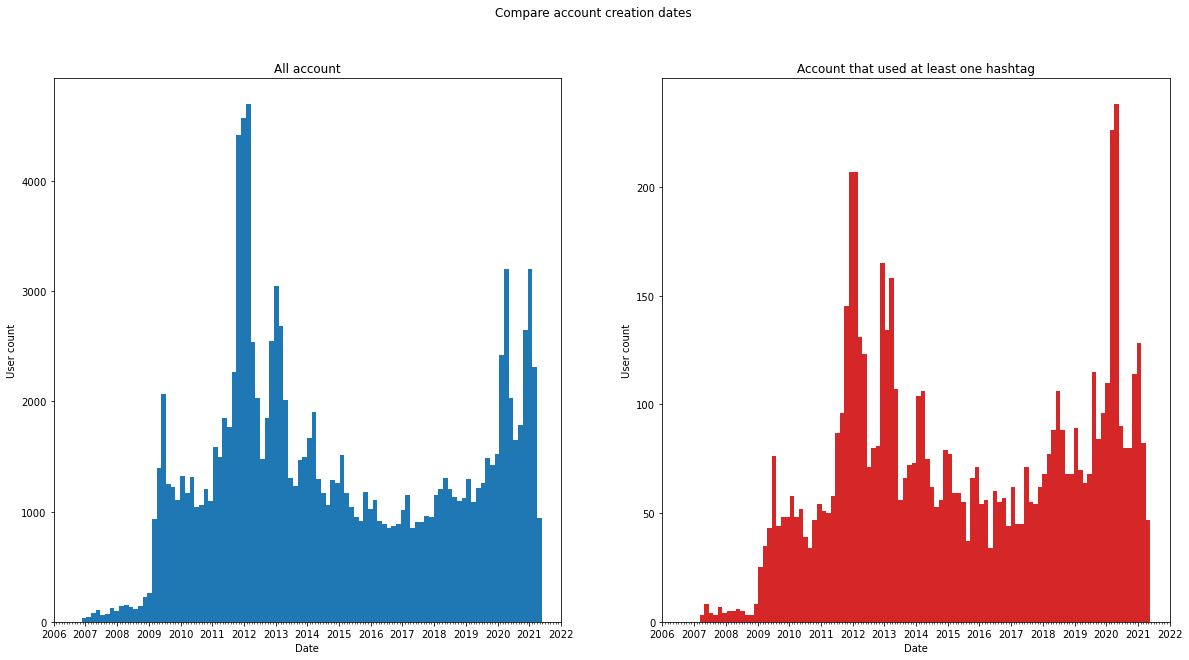

In [10]:
#Plot preparation
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Compare account creation dates')

#Plot with all the accounts
ax1.hist(dfUseHashtag["user_created_at"],bins=100)

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
datemin = datetime.date(dfUseHashtag["user_created_at"].sort_values()[0].year, 1, 1)
datemax = datetime.date(dfUseHashtag["user_created_at"].sort_values()[-1].year + 1, 1, 1)
ax1.set_xlim(datemin, datemax)

ax1.set_title("All account")
ax1.set_xlabel('Date')
ax1.set_ylabel('User count')


#Plot with the accounts that have used at leat one suspicious hastag
ax2.hist(dfUseHashtag.loc[dfUseHashtag['OR1'],'user_created_at'],bins=100,color='tab:red')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)
datemin = datetime.date(dfUseHashtag["user_created_at"].sort_values()[0].year, 1, 1)
datemax = datetime.date(dfUseHashtag["user_created_at"].sort_values()[-1].year + 1, 1, 1)
ax2.set_xlim(datemin, datemax)

ax2.set_title("Account that used at least one hashtag")
ax2.set_xlabel('Date')
ax2.set_ylabel('User count')


plt.show()

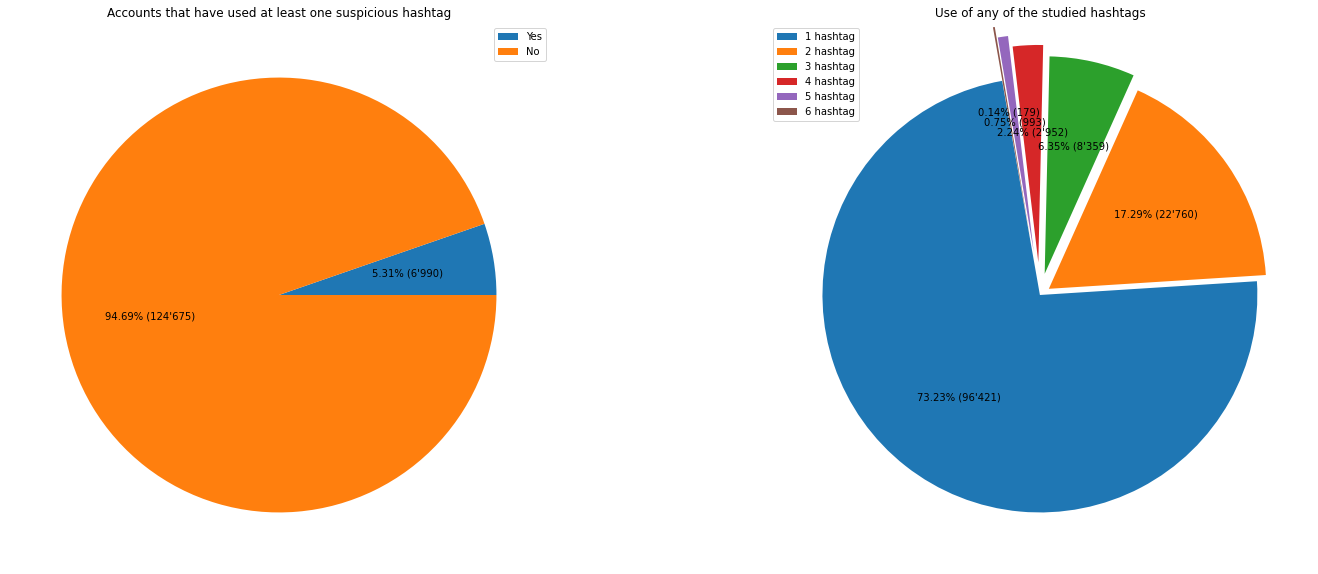

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10),gridspec_kw={'width_ratios': [1, 1]})

#Accounts that have used at least one suspicious hashtag
values = [sum(dfUseHashtag['OR1']), len(dfUseHashtag) - sum(dfUseHashtag['OR1'])]
names = ['Yes', 'No']
ax1.pie(values,autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''))
ax1.set_title('Accounts that have used at least one suspicious hashtag')
ax1.legend(labels=names)

#Use of any of the studied hashtags
df1 = pd.DataFrame()
for i in range(1,len(listHashtagsStudy)):
    df1.loc[i,'name'] = str(i)+' hashtag'
    df1.loc[i,'numHashtags'] = sum(dfUseHashtag['OR'+str(i)])

ax2.pie(df1.numHashtags,startangle = 100, explode = [0.0,0.05,0.1,0.15,0.20,0.25],
        autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''))
ax2.legend(labels=df1.name)
ax2.set_title('Use of any of the studied hashtags')

plt.show()

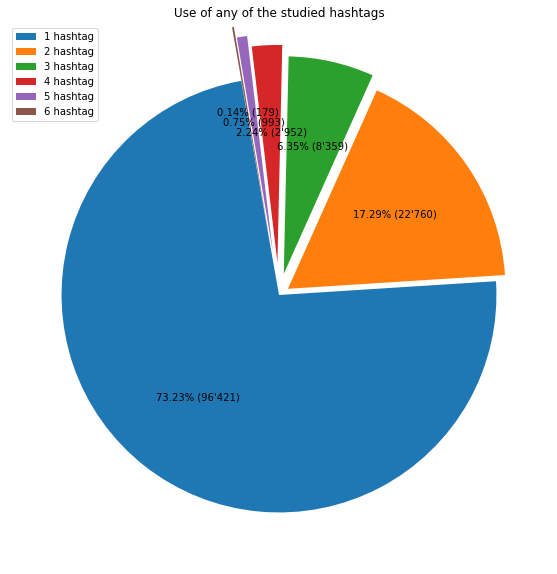

In [12]:
df1 = pd.DataFrame()
for i in range(1,len(listHashtagsStudy)):
    df1.loc[i,'name'] = str(i)+' hashtag'
    df1.loc[i,'numHashtags'] = sum(dfUseHashtag['OR'+str(i)])

plt.figure(figsize=(10, 10))
plt.pie(df1.numHashtags,startangle = 100, explode = [0.0,0.05,0.1,0.15,0.20,0.25],
        autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''))
plt.legend(labels=df1.name)
plt.title('Use of any of the studied hashtags')
plt.show()

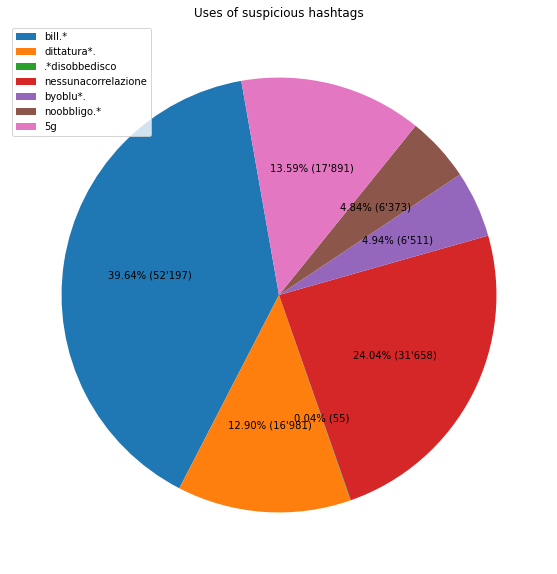

In [13]:
for i,h in enumerate(listHashtagsStudy):
    df1.loc[i,'name'] = h
    df1.loc[i,'numHashtags'] = sum(dfUseHashtag[h])
    
plt.figure(figsize=(10, 10))
plt.pie(df1.numHashtags,startangle = 100, autopct=lambda p:f'{p:.2f}% ({p*sum(values)/100 :,.0f})'.replace(',', '\''))
plt.legend(labels=df1.name)
plt.title('Uses of suspicious hashtags')
plt.show()

In [14]:
#Error code of user that uses this hashtag
print ("%d users have used a suspicious hashtag and have been suspended"
       %len(dfUseHashtag.loc[(dfUseHashtag['user_error']==63) & (dfUseHashtag['OR1']==True)]))
dfUseHashtag.loc[(dfUseHashtag['user_error']==63) & (dfUseHashtag['OR1']==True)]

39 users have used a suspicious hashtag and have been suspended


,5g,bill.*,dittatura*.,.*disobbedisco,nessunacorrelazione,byoblu*.,noobbligo.*,user_created_at,user_error,AND,OR1,OR2,OR3,OR4,OR5,OR6
user,,,,,,,,,,,,,,,,
Absolut32791095,False,False,True,False,False,False,True,2021-02-24 06:13:41+00:00,63.0,False,True,True,False,False,False,False
AlainMazzuno,False,False,False,False,True,False,False,2012-02-27 14:53:59+00:00,63.0,False,True,False,False,False,False,False
AlexTheMod,False,True,False,False,False,True,False,2009-06-02 17:21:55+00:00,63.0,False,True,True,False,False,False,False
Chuto_o_balde,False,False,True,False,False,False,False,2014-08-08 16:07:36+00:00,63.0,False,True,False,False,False,False,False
Epalermo2020,False,False,False,False,True,False,False,2020-09-14 23:36:05+00:00,63.0,False,True,False,False,False,False,False
FaggianoLepre,False,False,False,False,True,False,False,2020-12-31 14:34:50+00:00,63.0,False,True,False,False,False,False,False
GiovannaSandr16,False,False,False,False,True,True,True,2021-04-05 13:41:27+00:00,63.0,False,True,True,True,False,False,False
JonhDenv,False,False,False,False,True,False,False,2021-04-14 18:15:16+00:00,63.0,False,True,False,False,False,False,False
KentAllard23,False,True,False,False,False,False,False,2012-02-02 20:12:48+00:00,63.0,False,True,False,False,False,False,False


## Comparison with noVax users

In [15]:
dfNovax = pd.read_csv('../tweets_novax.csv',low_memory=False, usecols=['user_screen_name'])
user_novax = list(dfNovax.groupby('user_screen_name').first().index)

In [16]:
print('Users classified as no vax who use at least a certain number of "suspicious" hastags')
for i in range (1,7):
    or_i = "OR%d"%i
    df1 = dfUseHashtag[dfUseHashtag[or_i]]
    dfUseHashtagNovax = df1[df1.index.isin(user_novax)]
    print("\ti =",i,":\t",(len(dfUseHashtagNovax) / len(df1))*100,"%")

Users classified as no vax who use at least a certain number of "suspicious" hastags
	i = 1 :	 46.62374821173104 %
	i = 2 :	 78.78787878787878 %
	i = 3 :	 91.91419141914191 %
	i = 4 :	 96.26168224299066 %
	i = 5 :	 97.22222222222221 %
	i = 6 :	 100.0 %


In [17]:
dfUseByDate = ut.process_dfUse(df)
dfUseByDate

,Week/Year,hashtag,count
165526,2020-01-06,espertopoli,2
165467,2020-01-06,Taverna,1
165466,2020-01-06,TG24,1
165465,2020-01-06,TBC,1
165464,2020-01-06,StanleyPlotkin,5
...,...,...,...
25060,2021-05-17,fabriziopregliasco,1
25059,2021-05-17,fabriziocurcio,1
25058,2021-05-17,fabbriche,1
25056,2021-05-17,evidenzescientifiche,1


In [18]:
l = []
for h in dfUseByDate['hashtag'].unique():
    for r in listHashtagsStudy:
        if re.match(r,h):
            l.append(h)
l = list(set(l))

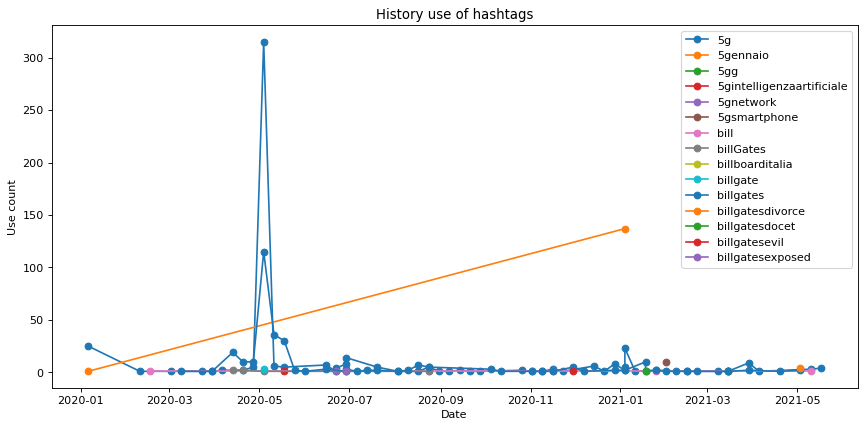

In [19]:
ut.visual_by_date_together(pd.DataFrame(l).groupby(0).count(),dfUseByDate,15)

In [20]:
dfUse

,user,5g,bill.*,dittatura*.,.*disobbedisco,nessunacorrelazione,byoblu*.,noobbligo.*
0,daniele19921,False,False,False,False,False,False,False
1,daniele19921,False,False,False,False,False,False,False
2,RossellaPierac3,False,False,False,False,False,False,False
3,RossellaPierac3,False,False,False,False,False,False,False
4,ZombieBuster5,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2172628,ELENAGORINI2,False,False,False,False,False,False,False
2172629,Katia48386800,False,False,False,False,False,False,False
2172630,PredragLecic,False,False,False,False,False,False,False
2172631,PredragLecic,False,False,False,False,False,False,False
